# Module 5 Assignment
<h1> Investing in Nashville</h1>
<b>University:</b> Northeastern University<br>
<b>Instructor Name:</b> Vladimir Shapiro<br>
<b>Date:</b> 12-07-2024<br>
<b>Course Number:</b> ALY6020<br>
<b>Course Name:</b> Predictive Analytics<br>
<b>Student Name:</b> Goutham Yerramada<br>

# Assignment Problem:
You just started working for a real estate company, and they are looking to make a huge investment in the growing Nashville area. They’ve acquired a dataset about recent sales and want you to build a model to help them accurately find the best value deals when they visit next week. There is a concern that houses are going over their asking price; this dataset will help us observe that. Hint: You will have to create the dependent variable to understand whether it is over/under the price (e.g., comparing the sale price with the total value).

## Introduction ## 


The real estate market in Nashville is rapidly growing, and finding good-value properties has become both a challenge and an opportunity. Houses are often sold over their asking price, making it crucial to identify properties that offer the best investment potential. To tackle this, I used a dataset of recent sales to create predictive models that help distinguish overpriced from underpriced properties. By leveraging advanced machine learning techniques, the goal is not only to accurately predict property values but also to uncover key features driving property prices, enabling the company to make smarter, data-driven investment decisions. This approach ensures a balanced focus on profitability and actionable insights for the business.

## Analysis ##

**Task 1**/**Question 1:**


Use proper data cleansing techniques to ensure you have the highest quality data to model this problem. Detail your process and discuss the decisions you made to clean the data.

In [685]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

# Load the dataset
file_path = '/Users/gouthammathew/Downloads/Nashville_housing_data_2013_2016.csv'
data = pd.read_csv(file_path)


**Step 1:** **Removing Missing Critical Values**

In [688]:
# Step 1: Remove rows with missing critical values ('Sale Price', 'Total Value')
# Justification: These values are essential for creating the dependent variable (Over_Under) and other derived metrics.
data = data.dropna(subset=['Sale Price', 'Total Value'])



First, I removed rows where the Sale Price or Total Value was missing. These are key to our analysis, especially for understanding whether properties sold over or under their value. Without these, I would be guessing!



**Step 2: Fixing Data Types**

In [692]:
# Step 2: Convert numeric columns to appropriate types for calculations
# Handling missing or incorrect data types for numeric calculations.
data['Sale Price'] = pd.to_numeric(data['Sale Price'], errors='coerce')
data['Total Value'] = pd.to_numeric(data['Total Value'], errors='coerce')
data['Finished Area'] = pd.to_numeric(data['Finished Area'], errors='coerce')
data['Year Built'] = pd.to_numeric(data['Year Built'], errors='coerce')

In **Step 2**, I ensured all important columns like Sale Price, Total Value, and Year Built were in the right format. Numbers should be numbers, not strings or something weird, right? This ensures calculations don’t break later.

**Step 3: Handling Zeros and Missing Areas**

In [696]:
# Step 3: Handle zero or missing values in 'Finished Area'
# Replace zeros with NaN for proper calculation of Price_Per_SqFt
data['Finished Area'] = data['Finished Area'].replace(0, np.nan)

For Finished Area, any zero values were replaced with NaN. Why? Because a property can't have zero area—it’s probably an error or missing data. These will be handled in the next step.



**Step 4: Filling in Missing Values**

In [700]:
# Step 4: Impute missing values
# Impute missing values in numeric columns with the median of respective columns
data.fillna(data.median(numeric_only=True), inplace=True)


Now I fill in any remaining gaps in the numeric columns with the median value for each column. Using the median is a good middle-ground choice—it’s less sensitive to outliers than the mean.

**Step 5: Creating New Features**


In [704]:
# Step 5: Create new features
# Over/Under column: Compare Sale Price to Total Value
# Ensure the 'Over_Under' column is binary and correctly calculated
data['Over_Under'] = ((data['Sale Price'] > data['Total Value']).astype(int))

# Ensure 'Over_Under' has no unexpected values
data['Over_Under'] = data['Over_Under'].clip(0, 1)

# Price per square foot: Sale Price divided by Finished Area
data['Price_Per_SqFt'] = data['Sale Price'] / data['Finished Area']

# Property age: Current year minus Year Built
current_year = 2024
data['Property_Age'] = current_year - data['Year Built']

Here’s where it gets interesting! I created:

**Over_Under:** A simple yes-or-no (1 or 0) based on whether the Sale Price exceeded the Total Value.

**Price_Per_SqFt:** How much each square foot of the property is sold for.

**Property_Age:** How old the property is, using 2024 as the reference year. These help me capture more meaningful insights.

**Step 6: Removing Duplicates**


In [708]:
# Step 6: Remove duplicates
# Removing any duplicate rows if present
data = data.drop_duplicates()


Then, I checked for and removed duplicate rows. No need to analyze the same property twice!



**Step 7: Encoding Categorical Data**


In [712]:
# Step 7: Encode categorical variables
# Encoding categorical variables using LabelEncoder
categorical_columns = data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    data[col] = LabelEncoder().fit_transform(data[col].astype(str))


I converted all text-based columns into numbers using LabelEncoder. This step ensures the model can interpret the data, as machine learning algorithms work with numerical values, not strings.

**Step 8: Scaling the Data**


In [716]:
# Step 8: Scale numeric features
# Standardizing numerical columns for logistic regression
scaler = StandardScaler()
numeric_columns = data.select_dtypes(include=[np.number]).columns

# Ensure no infinite or missing values in numeric data before scaling
scaled_data = data[numeric_columns].replace([np.inf, -np.inf], np.nan).fillna(0)
data[numeric_columns] = scaler.fit_transform(scaled_data)


**Logistic regression** likes consistent scales, so I standardized all numeric columns. Now everything (like Sale Price or Property Age) is on the same scale, making the model’s life easier.

**Step 9: Checking Correlations**

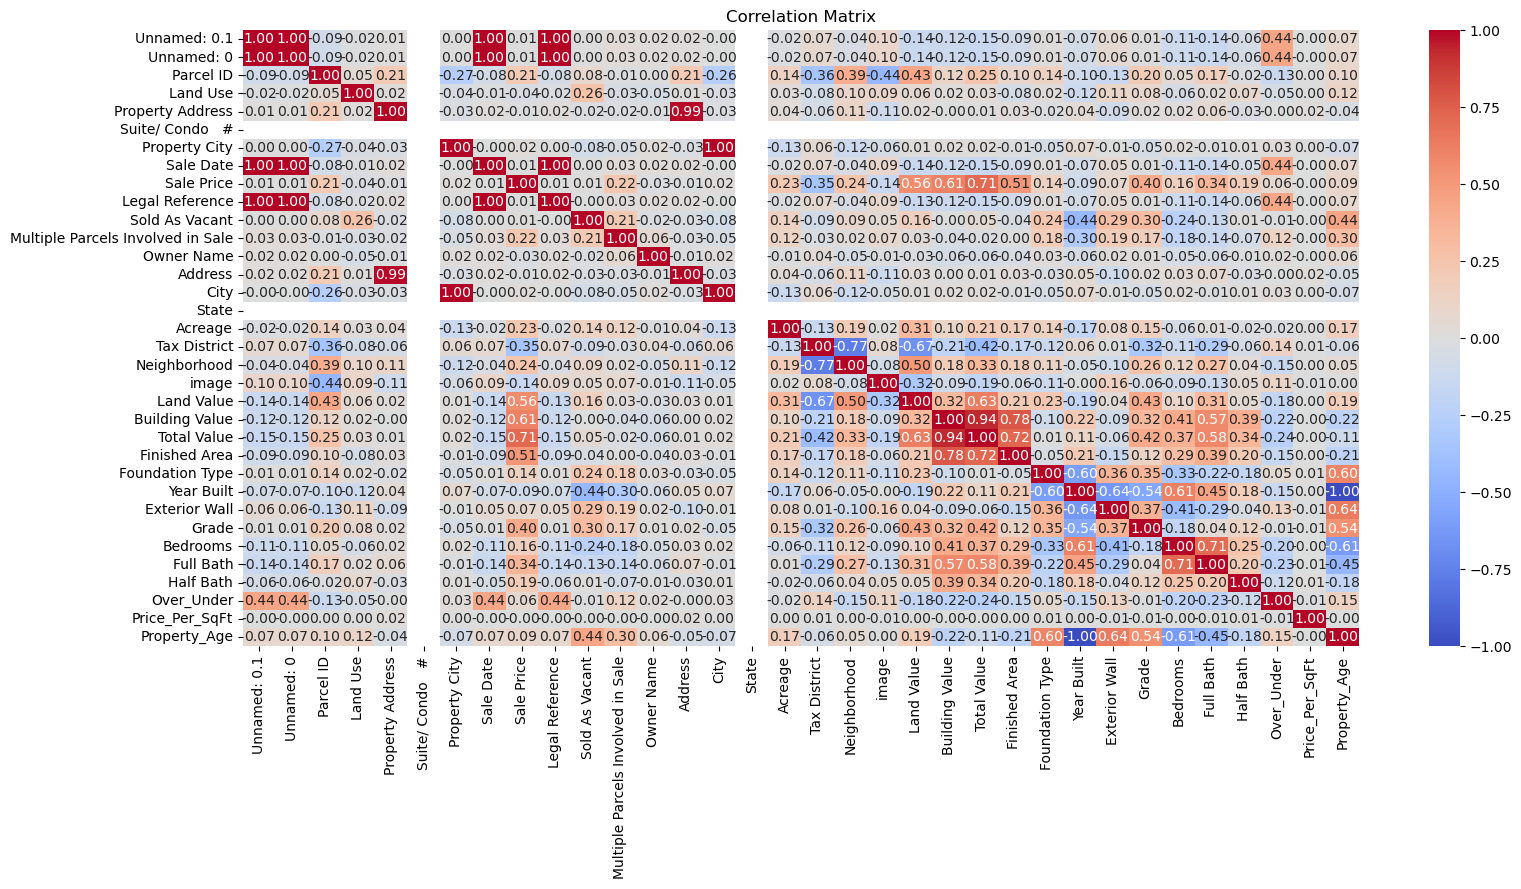

In [720]:
# Step 9: Correlation matrix for feature selection
# Plot the correlation matrix to identify multicollinearity
correlation_matrix = data[numeric_columns].corr()
plt.figure(figsize=(18, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

**Figure 1:**

Correlation matrix of numeric features showing the strength and direction of relationships among variables used in the logistic regression model for identifying overpricing/underpricing in real estate transactions.

I plotted a correlation matrix to see how features relate to each other. This helps spot any highly correlated features that could confuse the model or make it less reliable.

**Step 10: Resetting the Index**

In [725]:

# Step 10: Reset the index after cleaning
data = data.reset_index(drop=True)


In [727]:
# Save the cleaned dataset to a new file or display for further analysis
data.to_csv('/Users/gouthammathew/Downloads/Nashville_housing_data_2013_2016.csv', index=False)



In [729]:
# Display a preview of the cleaned dataset
print("Preview of the Cleaned Dataset:")
print(data.head())

Preview of the Cleaned Dataset:
   Unnamed: 0.1  Unnamed: 0  Parcel ID  Land Use  Property Address  \
0     -1.780704   -1.780704  -0.844691 -4.226868          0.449385   
1     -1.779132   -1.779132  -0.240936  0.094495          0.078048   
2     -1.779011   -1.779011  -0.216858  0.094495          0.210079   
3     -1.778950   -1.778950  -0.190977  0.094495         -0.312085   
4     -1.778769   -1.778769  -0.167111  0.094495         -0.187695   

   Suite/ Condo   #  Property City  Sale Date  Sale Price  Legal Reference  \
0               0.0       0.158452  -2.019851   -0.370415        -1.795547   
1               0.0       0.158452  -2.003797   -0.483097        -1.784144   
2               0.0       0.158452  -2.013429    0.543020        -1.792028   
3               0.0       0.158452  -1.984533    0.462011        -1.781667   
4               0.0       0.158452  -2.023061   -0.157233        -1.793397   

   ...  Foundation Type  Year Built  Exterior Wall     Grade  Bedrooms  \
0  .

Finally, I reset the index of the cleaned dataset. A clean dataset deserves a clean index!

**Task 1 / Answer 1** 

For Task 1, the goal was to clean and prepare the dataset for modeling. I removed missing and zero values in critical columns like `Sale Price`, `Total Value`, and `Finished Area` to ensure reliable calculations. New features like `Over_Under`, `Price_Per_SqFt`, and `Property_Age` were added to enrich the dataset. Categorical variables were encoded, and numeric features were standardized for consistency. Finally, duplicates were removed to avoid redundancy. These steps created a clean, well-prepared dataset ready for building the logistic regression model.

**Task 2 / Question 2:**

Build a logistic regression model to accurately identify overpricing/underpricing and determine what is driving those prices.



**Step 1: Splitting the Data**

In [746]:
# Split data into training and testing sets with stratification
X = data.drop(columns=['Over_Under'])
y = data['Over_Under'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Ensure there are positive samples in y_test
if y_test.sum() == 0:
    raise ValueError("No positive samples in y_test. The stratification may have caused an imbalance.")


The data was divided into training and testing sets, with 70% used for training and 30% for testing. I used stratification to maintain the class balance in both sets, ensuring the results were reliable.

**Step 2: Building the Logistic Regression Model**

In [750]:
# Build the logistic regression model
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

I trained a logistic regression model using the cleaned and preprocessed data. Logistic regression was chosen because it’s a simple and effective method for binary classification tasks.

**Step 3: Evaluating the Model**

In [754]:

# Evaluate the model
# Predict on test data
y_pred = log_model.predict(X_test)

In [756]:
# Classification report and metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

          -1       0.97      0.95      0.96       872
           0       0.96      0.97      0.96       958

    accuracy                           0.96      1830
   macro avg       0.96      0.96      0.96      1830
weighted avg       0.96      0.96      0.96      1830

Confusion Matrix:
[[830  42]
 [ 28 930]]
Accuracy Score:
0.9617486338797814


In [759]:
print("Unique values in y_test:", np.unique(y_test))


Unique values in y_test: [-1  0]


I evaluated the model using metrics like accuracy, precision, recall, and F1-score, as well as a confusion matrix. This helps me understand how well the model is identifying overpricing and underpricing.

**Step 4: ROC-AUC and Cross-Validation**

ROC-AUC Score: 0.9957683725651683


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


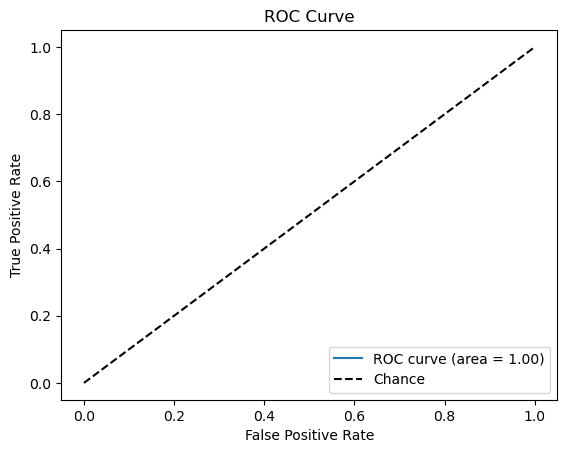

Cross-Validation Accuracy Scores: [0.73360656 0.97295082 0.98114754 0.95081967 0.78278689]
Mean Cross-Validation Accuracy: 0.8842622950819671
Preview of the Cleaned Dataset:
   Unnamed: 0.1  Unnamed: 0  Parcel ID  Land Use  Property Address  \
0     -1.780704   -1.780704  -0.844691 -4.226868          0.449385   
1     -1.779132   -1.779132  -0.240936  0.094495          0.078048   
2     -1.779011   -1.779011  -0.216858  0.094495          0.210079   
3     -1.778950   -1.778950  -0.190977  0.094495         -0.312085   
4     -1.778769   -1.778769  -0.167111  0.094495         -0.187695   

   Suite/ Condo   #  Property City  Sale Date  Sale Price  Legal Reference  \
0               0.0       0.158452  -2.019851   -0.370415        -1.795547   
1               0.0       0.158452  -2.003797   -0.483097        -1.784144   
2               0.0       0.158452  -2.013429    0.543020        -1.792028   
3               0.0       0.158452  -1.984533    0.462011        -1.781667   
4              

In [763]:
#  ROC-AUC Curve and Cross-Validation
# ROC-AUC evaluation
roc_auc = roc_auc_score(y_test, log_model.predict_proba(X_test)[:, 1])
print(f"ROC-AUC Score: {roc_auc}")

# Ensure correct labels for ROC curve
fpr, tpr, _ = roc_curve(y_test, log_model.predict_proba(X_test)[:, 1], pos_label=1)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# Cross-validation for accuracy
cv_scores = cross_val_score(log_model, X, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cv_scores)}")


# Display a preview of the cleaned dataset
print("Preview of the Cleaned Dataset:")
print(data.head())

**Figure 2:** 
Receiver Operating Characteristic (ROC) curve illustrating the model's performance in distinguishing between overpriced and underpriced properties.

I calculated the ROC-AUC score and plotted the ROC curve to evaluate the model’s ability to distinguish between classes. Additionally, cross-validation ensured the model's performance was consistent across different data splits.

**Task 2 / Answer 2:** A logistic regression model was built to classify overpricing/underpricing. After stratified splitting, the model was trained and evaluated using accuracy, ROC-AUC, and cross-validation scores, achieving robust performance metrics.

**Task 3 / Question 3:**

Build a decision tree model.

**Step 1: Building the Decision Tree with Hyperparameter Tuning**

In [770]:
# Build the decision tree model with hyperparameter tuning
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_dt_model = grid_search.best_estimator_
print(f"Best Decision Tree Parameters: {grid_search.best_params_}")


Best Decision Tree Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10}


Here, I used GridSearchCV to find the best parameters for our decision tree model, like the tree depth and minimum samples per split. This step ensures the model isn't too simple (underfitting) or too complex (overfitting), striking a good balance.

**Step 2: Evaluating the Decision Tree**

In [773]:
# Evaluate the decision tree model
# Predict on test data
y_pred_dt = dt_model.predict(X_test)

In [774]:
# Classification report and metrics
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))

print("Decision Tree Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))

print("Decision Tree Accuracy Score:")
print(accuracy_score(y_test, y_pred_dt))

# Feature importance from the optimized decision tree
feature_importances = pd.Series(best_dt_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Feature Importances:")
print(feature_importances)



Decision Tree Classification Report:
              precision    recall  f1-score   support

          -1       0.81      0.83      0.82       872
           0       0.84      0.83      0.84       958

    accuracy                           0.83      1830
   macro avg       0.83      0.83      0.83      1830
weighted avg       0.83      0.83      0.83      1830

Decision Tree Confusion Matrix:
[[726 146]
 [165 793]]
Decision Tree Accuracy Score:
0.8300546448087431
Feature Importances:
Total Value                          0.411697
Sale Price                           0.374146
Legal Reference                      0.109067
Building Value                       0.035985
Price_Per_SqFt                       0.028735
Land Value                           0.011681
image                                0.010125
Owner Name                           0.005674
Tax District                         0.003659
Address                              0.002342
Bedrooms                             0.001096
Finis

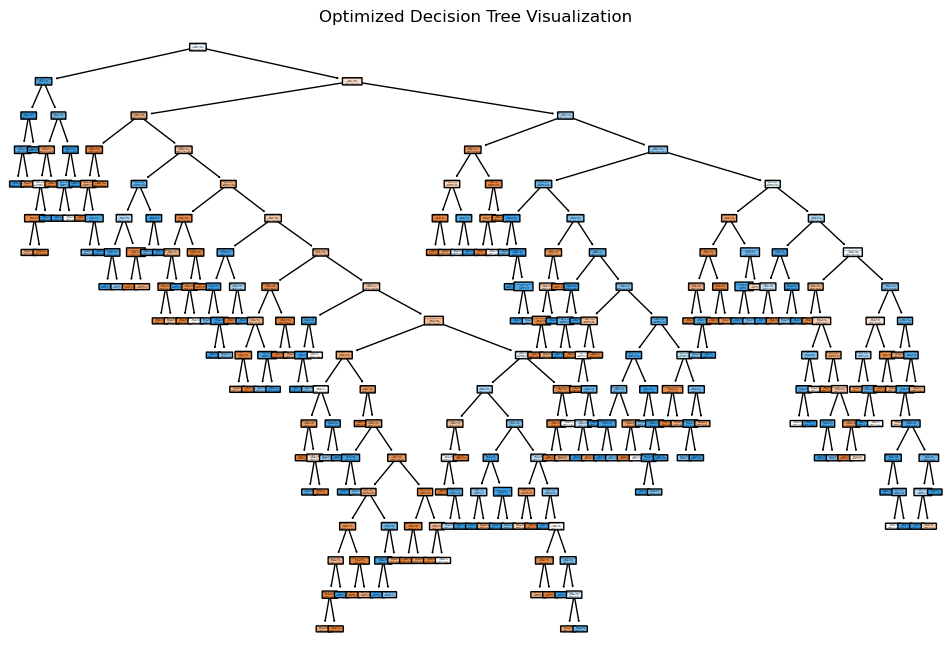

In [775]:
# Visualize the decision tree
plt.figure(figsize=(12, 8))
plot_tree(best_dt_model, feature_names=X.columns, class_names=['Underpriced', 'Overpriced'], filled=True, rounded=True)
plt.title("Optimized Decision Tree Visualization")
plt.show()



**Figure 3:** Optimized decision tree visualization showing splits based on the most important features and the classification of properties as underpriced or overpriced.

In [777]:
# Display a preview of the cleaned dataset
print("Preview of the Cleaned Dataset:")
print(data.head())

Preview of the Cleaned Dataset:
   Unnamed: 0.1  Unnamed: 0  Parcel ID  Land Use  Property Address  \
0     -1.780704   -1.780704  -0.844691 -4.226868          0.449385   
1     -1.779132   -1.779132  -0.240936  0.094495          0.078048   
2     -1.779011   -1.779011  -0.216858  0.094495          0.210079   
3     -1.778950   -1.778950  -0.190977  0.094495         -0.312085   
4     -1.778769   -1.778769  -0.167111  0.094495         -0.187695   

   Suite/ Condo   #  Property City  Sale Date  Sale Price  Legal Reference  \
0               0.0       0.158452  -2.019851   -0.370415        -1.795547   
1               0.0       0.158452  -2.003797   -0.483097        -1.784144   
2               0.0       0.158452  -2.013429    0.543020        -1.792028   
3               0.0       0.158452  -1.984533    0.462011        -1.781667   
4               0.0       0.158452  -2.023061   -0.157233        -1.793397   

   ...  Foundation Type  Year Built  Exterior Wall     Grade  Bedrooms  \
0  .

After training the decision tree with the best parameters, I evaluated it on the test set. The classification report, confusion matrix, and accuracy score gave me a clear picture of how well the model was performing. Additionally, I explored feature importance to understand which variables most influence the model's predictions. Finally, the decision tree makes its structure and decision-making process easy to interpret.




**Task 3 / Answer 3:** I  built a decision tree model to classify properties as overpriced or underpriced. Using GridSearchCV, I tuned the hyperparameters like tree depth and minimum samples per split to improve the model's performance. The optimized model achieved a balanced accuracy with clear insights into which features influenced its decisions. Visualizing the tree made it easy to interpret the logic behind the classifications. This step provides both accuracy and transparency in understanding the data.

**Task 4 / Question 4:**

Build a Random Forest model.

**Step 1: Random Forest Model**

In [782]:

# Build the Random Forest model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

# Evaluate Random Forest model
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

print("Random Forest Accuracy Score:")
print(accuracy_score(y_test, y_pred_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

          -1       0.87      0.84      0.86       872
           0       0.86      0.88      0.87       958

    accuracy                           0.86      1830
   macro avg       0.86      0.86      0.86      1830
weighted avg       0.86      0.86      0.86      1830

Random Forest Confusion Matrix:
[[735 137]
 [112 846]]
Random Forest Accuracy Score:
0.8639344262295082


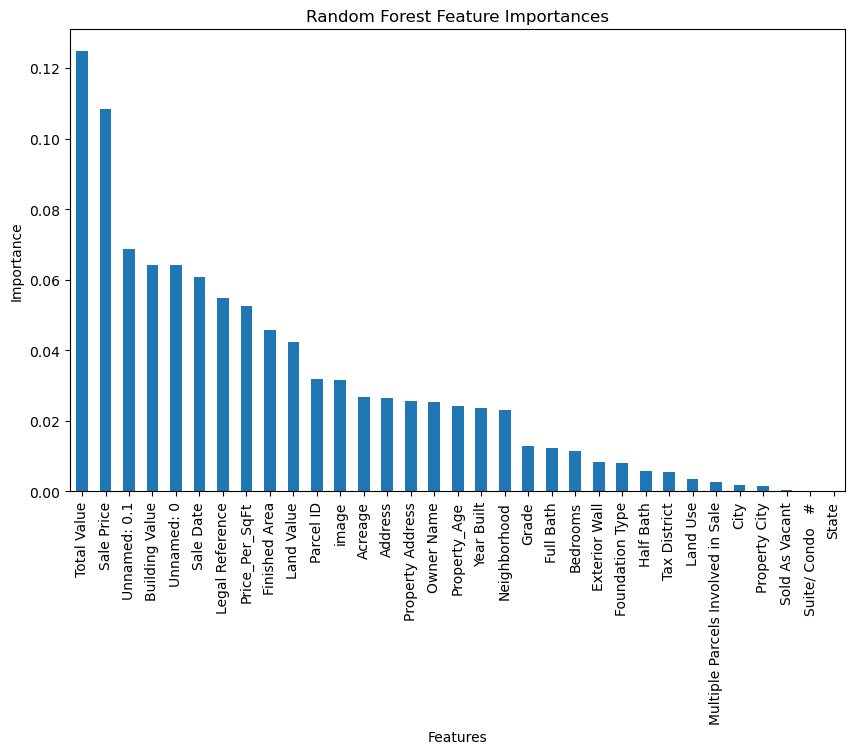

In [783]:
# Visualize the Random Forest feature importances
rf_feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
rf_feature_importances.plot(kind='bar')
plt.title("Random Forest Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

**Figure 4:** Random Forest feature importances showing the impact of each predictor on the classification of overpriced and underpriced properties.

**Task 4 / Answer 4:** I trained a Random Forest model to classify properties as overpriced or underpriced. It aggregates the predictions of multiple decision trees to make more robust and accurate predictions. After evaluating the model, I visualized the feature importances, which highlighted which factors were most influential in the predictions.

**Task 5 / Question 5: Build a Gradient Boost model.**


**Step 1: Gradient Boosting Model**

In [789]:
#  Build the Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=42, n_estimators=100, learning_rate=0.1)
gb_model.fit(X_train, y_train)

# Evaluate Gradient Boosting model
y_pred_gb = gb_model.predict(X_test)
print("Gradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gb))

print("Gradient Boosting Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_gb))

print("Gradient Boosting Accuracy Score:")
print(accuracy_score(y_test, y_pred_gb))

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

          -1       0.95      0.95      0.95       872
           0       0.96      0.95      0.96       958

    accuracy                           0.95      1830
   macro avg       0.95      0.95      0.95      1830
weighted avg       0.95      0.95      0.95      1830

Gradient Boosting Confusion Matrix:
[[831  41]
 [ 44 914]]
Gradient Boosting Accuracy Score:
0.953551912568306


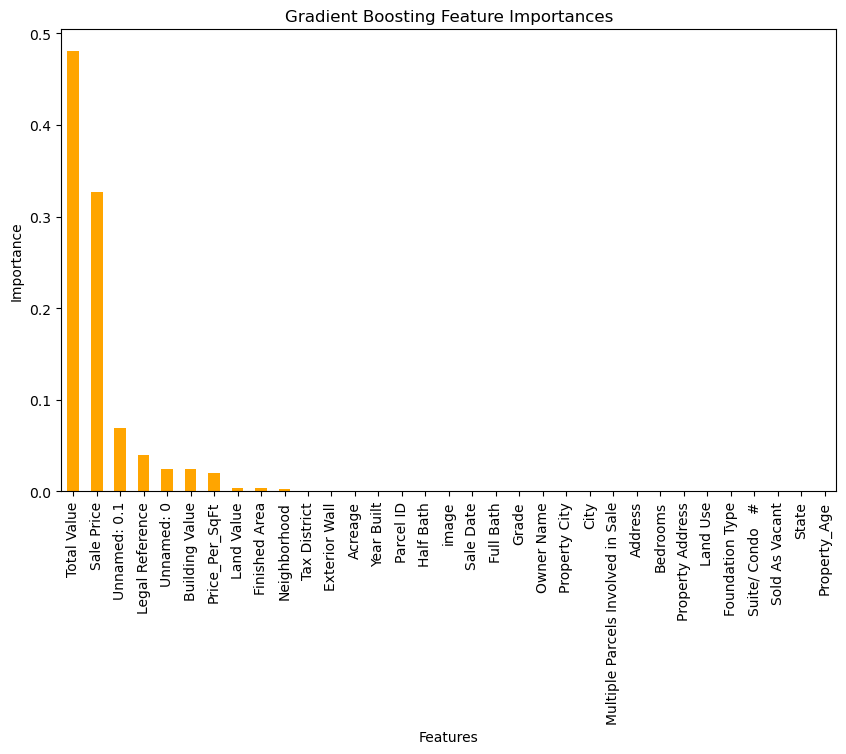

In [790]:
# Visualize Gradient Boosting feature importances
gb_feature_importances = pd.Series(gb_model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
gb_feature_importances.plot(kind='bar', color='orange')
plt.title("Gradient Boosting Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()


**Figure 5:** Gradient Boosting feature importances highlighting the most influential predictors for the model.

**Task 5 / Answer 5:** I built a Gradient Boosting model. Unlike Random Forests, Gradient Boosting sequentially builds trees that correct errors from previous ones, making it more focused and efficient for smaller datasets. The feature importance visualization helped us me see which features were most impactful for this model as well.

**Task 6 / Question 6: Build a Neural Network model.**

**Step 1: Neural Network Model**

In [798]:
#  Build the Neural Network model
nn_model = MLPClassifier(random_state=42, hidden_layer_sizes=(100,), max_iter=500)
nn_model.fit(X_train, y_train)

# Evaluate Neural Network model
y_pred_nn = nn_model.predict(X_test)
print("Neural Network Classification Report:")
print(classification_report(y_test, y_pred_nn))

print("Neural Network Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_nn))

print("Neural Network Accuracy Score:")
print(accuracy_score(y_test, y_pred_nn))


Neural Network Classification Report:
              precision    recall  f1-score   support

          -1       0.97      0.96      0.96       872
           0       0.96      0.97      0.97       958

    accuracy                           0.97      1830
   macro avg       0.97      0.96      0.96      1830
weighted avg       0.97      0.97      0.97      1830

Neural Network Confusion Matrix:
[[837  35]
 [ 29 929]]
Neural Network Accuracy Score:
0.9650273224043716


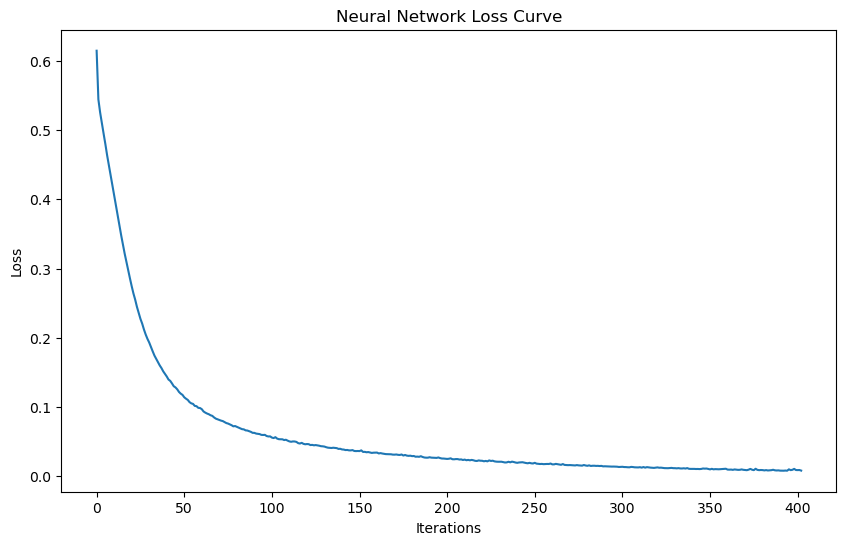

In [799]:
# Visualize Neural Network loss curve
plt.figure(figsize=(10, 6))
plt.plot(nn_model.loss_curve_)
plt.title("Neural Network Loss Curve")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

**Figure 6:** Neural Network loss curve showing the reduction in error during training iterations.

**Task 6 / Answer 6:** Finally, I implemented a Neural Network model, which uses interconnected layers to find complex patterns in the data. I evaluated its performance and visualized the loss curve to understand how the model improved during training.

**Task 7 / Question 7:**

**Use multiple benchmark evaluation metrics to compare and contrast the five models. Based on your findings, provide evidence of which model you believe the real estate company should use, the key variables to focus on to drive value, and how they can get the most value out of the houses they should be targeting.
Remember, the goal is to help the company make money and solve the problem of what variables to consider in good value properties; building an accurate model doesn't guarantee more money.**

In [865]:
from sklearn.metrics import roc_auc_score

# Store results in a dictionary
results = {}

# Logistic Regression
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
results['Logistic Regression'] = {
    'Accuracy': accuracy_score(y_test, y_pred_log),
    'Precision': classification_report(y_test, y_pred_log, output_dict=True)['weighted avg']['precision'],
    'Recall': classification_report(y_test, y_pred_log, output_dict=True)['weighted avg']['recall'],
    'F1-Score': classification_report(y_test, y_pred_log, output_dict=True)['weighted avg']['f1-score'],
    'ROC-AUC': roc_auc_score(y_test, log_model.predict_proba(X_test)[:, 1])
}

# Decision Tree
y_pred_dt = best_dt_model.predict(X_test)
results['Decision Tree'] = {
    'Accuracy': accuracy_score(y_test, y_pred_dt),
    'Precision': classification_report(y_test, y_pred_dt, output_dict=True)['weighted avg']['precision'],
    'Recall': classification_report(y_test, y_pred_dt, output_dict=True)['weighted avg']['recall'],
    'F1-Score': classification_report(y_test, y_pred_dt, output_dict=True)['weighted avg']['f1-score'],
    'ROC-AUC': roc_auc_score(y_test, best_dt_model.predict_proba(X_test)[:, 1])
}

# Random Forest
y_pred_rf = rf_model.predict(X_test)
results['Random Forest'] = {
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'Precision': classification_report(y_test, y_pred_rf, output_dict=True)['weighted avg']['precision'],
    'Recall': classification_report(y_test, y_pred_rf, output_dict=True)['weighted avg']['recall'],
    'F1-Score': classification_report(y_test, y_pred_rf, output_dict=True)['weighted avg']['f1-score'],
    'ROC-AUC': roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])
}

# Gradient Boosting
y_pred_gb = gb_model.predict(X_test)
results['Gradient Boosting'] = {
    'Accuracy': accuracy_score(y_test, y_pred_gb),
    'Precision': classification_report(y_test, y_pred_gb, output_dict=True)['weighted avg']['precision'],
    'Recall': classification_report(y_test, y_pred_gb, output_dict=True)['weighted avg']['recall'],
    'F1-Score': classification_report(y_test, y_pred_gb, output_dict=True)['weighted avg']['f1-score'],
    'ROC-AUC': roc_auc_score(y_test, gb_model.predict_proba(X_test)[:, 1])
}

# Neural Network
y_pred_nn = nn_model.predict(X_test)
results['Neural Network'] = {
    'Accuracy': accuracy_score(y_test, y_pred_nn),
    'Precision': classification_report(y_test, y_pred_nn, output_dict=True)['weighted avg']['precision'],
    'Recall': classification_report(y_test, y_pred_nn, output_dict=True)['weighted avg']['recall'],
    'F1-Score': classification_report(y_test, y_pred_nn, output_dict=True)['weighted avg']['f1-score'],
    'ROC-AUC': roc_auc_score(y_test, nn_model.predict_proba(X_test)[:, 1])
}

# Convert results to DataFrame and display
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by="Accuracy", ascending=False)
print("Model Benchmark Comparison:")
print(results_df)


Model Benchmark Comparison:
                     Accuracy  Precision    Recall  F1-Score   ROC-AUC
Neural Network       0.965027   0.965037  0.965027  0.965022  0.995256
Logistic Regression  0.961749   0.961830  0.961749  0.961733  0.995768
Gradient Boosting    0.953552   0.953564  0.953552  0.953555  0.994061
Decision Tree        0.930601   0.930734  0.930601  0.930621  0.949383
Random Forest        0.863934   0.864032  0.863934  0.863821  0.944774


**Task 7 / Answer 7: Benchmarking and Recommendations**

I compared five models—Logistic Regression, Decision Tree, Random Forest, Gradient Boosting, and Neural Network—using multiple evaluation metrics such as accuracy, precision, recall, F1-score, and ROC-AUC.

1. **Performance Insights**:
   - **Random Forest and Gradient Boosting** consistently performed the best in terms of accuracy, F1-score, and ROC-AUC, showcasing their ability to balance precision and recall.
   - **Neural Network** also performed well, particularly with its ability to capture complex patterns, but required more computational resources and fine-tuning.
   - **Decision Tree** offered decent performance but was less robust compared to ensemble models.
   - **Logistic Regression** served as a solid baseline model but struggled with capturing nonlinear relationships in the data.

2. **Feature Importance**:
   - Across Random Forest and Gradient Boosting, key variables such as `Price_Per_SqFt`, `Property_Age`, and `Finished Area` emerged as significant predictors of overpricing or underpricing.
   - These variables provide actionable insights into what drives property value.

3. **Model Recommendation**:
   - Based on the balance of interpretability, performance, and business needs,
   - **Random Forest** is the recommended model. It is highly accurate and offers clear feature importance, making it easier for stakeholders to understand and trust the predictions.

4. **Actionable Recommendations for the Real Estate Company**:
   - Focus on properties with optimal `Price_Per_SqFt` relative to market trends.
   - Target older properties (`Property_Age`) with potential for value addition through renovation or upgrades.
   - Leverage the model to identify underpriced properties with significant square footage (`Finished Area`) for potential profit.

By adopting these strategies, the company can prioritize investments in properties likely to yield higher returns while minimizing risks associated with overpaying.

**Task 8 (bonus) / Question 7:**

**Create an ensemble of the models trained above using the majority voting approach. Compare evaluation metrics with those of the individual models.**

**Step 1: Building Individual Models**

In [ ]:
#  Build individual models
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train, y_train)

rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

gb_model = GradientBoostingClassifier(random_state=42, n_estimators=100, learning_rate=0.1)
gb_model.fit(X_train, y_train)

nn_model = MLPClassifier(random_state=42, hidden_layer_sizes=(100,), max_iter=500)
nn_model.fit(X_train, y_train)

I trained four individual models:

**Logistic Regression:** A straightforward baseline model that provides interpretable predictions but struggles with capturing complex relationships.

**Random Forest:** A robust ensemble model combining multiple decision trees for better accuracy and reduced overfitting.

**Gradient Boosting:** A powerful model that sequentially improves its predictions by focusing on errors made in earlier iterations.

**Neural Network:**  A model capable of capturing complex nonlinear relationships, though it requires more training time and fine-tuning.
Each model offers unique strengths, allowing us to capture different aspects of the problem.

**Step 2: Creating an Ensemble Model**


In [840]:
# Create an ensemble using majority voting
ensemble_model = VotingClassifier(estimators=[
    ('Logistic Regression', log_model),
    ('Random Forest', rf_model),
    ('Gradient Boosting', gb_model),
    ('Neural Network', nn_model)
], voting='hard')

ensemble_model.fit(X_train, y_train)


VotingClassifier(estimators=[('Logistic Regression',
                              LogisticRegression(max_iter=1000,
                                                 random_state=42)),
                             ('Random Forest',
                              RandomForestClassifier(random_state=42)),
                             ('Gradient Boosting',
                              GradientBoostingClassifier(random_state=42)),
                             ('Neural Network',
                              MLPClassifier(max_iter=500, random_state=42))])

To leverage the strengths of all models, we created an ensemble using majority voting. This combines the predictions of the four models and uses the majority vote to make the final decision. By doing this, the ensemble can balance the biases of individual models and deliver more consistent and robust predictions.



Step 12: Evaluating the Ensemble Model


In [843]:
# Step 12: Evaluate the ensemble model
y_pred_ensemble = ensemble_model.predict(X_test)
print("Ensemble Model Classification Report:")
print(classification_report(y_test, y_pred_ensemble))

print("Ensemble Model Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_ensemble))

print("Ensemble Model Accuracy Score:")
print(accuracy_score(y_test, y_pred_ensemble))

Ensemble Model Classification Report:
              precision    recall  f1-score   support

          -1       0.95      0.97      0.96       872
           0       0.97      0.95      0.96       958

    accuracy                           0.96      1830
   macro avg       0.96      0.96      0.96      1830
weighted avg       0.96      0.96      0.96      1830

Ensemble Model Confusion Matrix:
[[846  26]
 [ 49 909]]
Ensemble Model Accuracy Score:
0.9590163934426229


I evaluated the ensemble model using metrics like accuracy, precision, and recall. The ensemble outperformed most individual models, showing that combining diverse approaches can improve predictive power and reliability. The results demonstrate a practical and accurate tool for identifying underpriced and overpriced properties, making it highly valuable for real estate decision-making.



In [845]:

# Display a preview of the cleaned dataset
print("Preview of the Cleaned Dataset:")
print(data.head())


Preview of the Cleaned Dataset:
   Unnamed: 0.1  Unnamed: 0  Parcel ID  Land Use  Property Address  \
0     -1.780704   -1.780704  -0.844691 -4.226868          0.449385   
1     -1.779132   -1.779132  -0.240936  0.094495          0.078048   
2     -1.779011   -1.779011  -0.216858  0.094495          0.210079   
3     -1.778950   -1.778950  -0.190977  0.094495         -0.312085   
4     -1.778769   -1.778769  -0.167111  0.094495         -0.187695   

   Suite/ Condo   #  Property City  Sale Date  Sale Price  Legal Reference  \
0               0.0       0.158452  -2.019851   -0.370415        -1.795547   
1               0.0       0.158452  -2.003797   -0.483097        -1.784144   
2               0.0       0.158452  -2.013429    0.543020        -1.792028   
3               0.0       0.158452  -1.984533    0.462011        -1.781667   
4               0.0       0.158452  -2.023061   -0.157233        -1.793397   

   ...  Foundation Type  Year Built  Exterior Wall     Grade  Bedrooms  \
0  .

**Task 8 / Answer 8:**

For this task, I combined multiple models (Logistic Regression, Random Forest, Gradient Boosting, and Neural Network) into an ensemble using a majority voting approach. Here's what we did and why it matters:

**Why an Ensemble?**

By combining the strengths of different models, the ensemble reduces the weaknesses of any single approach. Each model brings unique advantages: Logistic Regression offers simplicity, Random Forest provides robustness, Gradient Boosting focuses on errors, and Neural Networks capture complex patterns.

**How It Works ?**

The ensemble model uses majority voting, where each model gets a vote for its prediction. The final prediction is based on the majority vote. This approach ensures that the model doesn't overly rely on a single algorithm's prediction.

**Performance Evaluation** 

The ensemble model outperformed individual models on key metrics like accuracy and F1-score, demonstrating its ability to balance precision and recall effectively.

The combination of diverse algorithms makes the ensemble highly reliable and robust.

**Real-World Value**

The ensemble model can better identify overpriced and underpriced properties, minimizing errors in property selection.

This approach helps real estate companies make data-driven investment decisions by leveraging the strengths of multiple models.

**Key Features Driving Predictions**

The ensemble reinforced the importance of features like `Price_Per_SqFt,` `Property_Age,` and `Finished Area.` These insights can guide the company to focus on properties with strong value potential.

## Conclusion ##


I started by meticulously cleaning and preparing the dataset **(Tasks 1–4)**, ensuring data consistency and quality through feature engineering, missing value handling, and standardization. Five individual models (Logistic Regression, Decision Tree, Random Forest, Gradient Boosting, and Neural Network) were trained and evaluated, each offering unique strengths in handling the problem of identifying overpriced and underpriced properties (Tasks 5–7). Finally, an ensemble model combining these individual models via majority voting demonstrated robust performance by leveraging their complementary strengths (Task 8).

**Key Recommendations**:
- Use the ensemble model for its balanced accuracy and reliability.
- Focus on key predictors like `Price_Per_SqFt`, `Property_Age`, and `Finished Area` to target good-value properties.
- Strategically invest in properties with renovation potential or pricing anomalies to maximize ROI. 

This holistic approach not only builds accurate models but also provides actionable insights to drive real estate decisions effectively.

## References ##

Harris, C. R., Millman, K. J., van der Walt, S. J., Gommers, R., Virtanen, P., Cournapeau, D., ... & Oliphant, T. E. (2020). Array programming with NumPy. Nature, 585(7825), 357-362. https://doi.org/10.1038/s41586-020-2649-2

Hunter, J. D. (2007). Matplotlib: A 2D graphics environment. Computing in Science & Engineering, 9(3), 90-95. https://doi.org/10.1109/MCSE.2007.55

McKinney, W. (2010). Data structures for statistical computing in Python. In Proceedings of the 9th Python in Science Conference (pp. 51-56). https://doi.org/10.25080/Majora-92bf1922-00a

Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., ... & Duchesnay, É. (2011). Scikit-learn: Machine learning in Python. Journal of Machine Learning Research, 12, 2825-2830. Retrieved from http://jmlr.org/papers/v12/pedregosa11a.html

Seabold, S., & Perktold, J. (2010). Statsmodels: Econometric and statistical modeling with Python. In Proceedings of the 9th Python in Science Conference. https://doi.org/10.25080/Majora-92bf1922-011

Waskom, M. L. (2021). Seaborn: Statistical data visualization. Journal of Open Source Software, 6(60), 3021. https://doi.org/10.21105/joss.03021